## Imports

In [1]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
# We use OneVsRestClassifier for multi-label prediction
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
kfold = KFold(5, True, 1)

## Reading Data

In [2]:
data = pd.read_csv('zoo.data', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


### Dropping name column as its irrelevant

In [3]:
df = data.drop(0, axis=1)
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


### Seperating independent variables and dependent variables

In [4]:
X = df.iloc[:,:-1].values
Y = df.iloc[:,-1].values

### SVM's with different kernels

In [5]:
svc_linear = svm.SVC(C=1, kernel='linear')
svc_rbf = svm.SVC(C=1, kernel='rbf')
svc_poly = svm.SVC(C=1, kernel='poly')
svc_sigmoid = svm.SVC(C=1, kernel='sigmoid')

### Cross-Validation score calculation

In [6]:
linear_svc_score = [svc_linear.fit(X[train], Y[train]).score(X[test], Y[test]) for train, test in kfold.split(df)]
rbf_svc_score = [svc_rbf.fit(X[train], Y[train]).score(X[test], Y[test]) for train, test in kfold.split(df)]
poly_svc_score = [svc_poly.fit(X[train], Y[train]).score(X[test], Y[test]) for train, test in kfold.split(df)]
sigmoid_svc_score = [svc_sigmoid.fit(X[train], Y[train]).score(X[test], Y[test]) for train, test in kfold.split(df)]

In [7]:
scores = pd.DataFrame({'linear':linear_svc_score, 'poly':poly_svc_score, 'rbf':rbf_svc_score, 'sigmoid':sigmoid_svc_score})

In [8]:
scores.head()

,linear,poly,rbf,sigmoid
0,0.952381,0.857143,0.904762,0.761905
1,0.950000,0.850000,0.900000,0.600000
2,1.000000,0.900000,0.850000,0.700000
3,0.950000,0.850000,0.850000,0.650000
4,0.900000,0.900000,0.900000,0.850000


**Linear Kernel showed best result across all 5 folds showing all 7 classes are seperated by linear hyperplane in 2D graph.**

<Figure size 720x576 with 0 Axes>

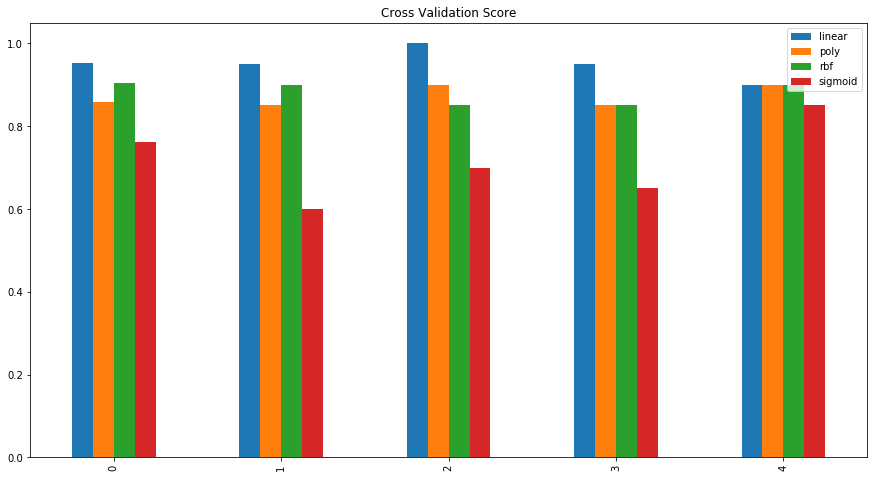

In [9]:
plt.figure(figsize=(10,8))
scores.plot.bar(figsize=(15, 8))
plt.legend()
plt.title("Cross Validation Score")
plt.show()

In [10]:
# Use label_binarize to be multi-label like settings
y = label_binarize(Y, classes=[1,2,3,4,5,6,7])
n_classes = 7
# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.3,
                                                    random_state=1)

### Evaluation function 
For calculation of average precison score for each class with different classifiers. It also calculated precision recall graph for SVM's and Neural Network based classifiers.

In [11]:
def evaluate(c):
    # Run classifier
    if c is 'linear':
        classifier = OneVsRestClassifier(svm.SVC(C=1, kernel='linear', probability=True, random_state=1))
    elif c is 'rbf':
        classifier = OneVsRestClassifier(svm.SVC(C=1, kernel='rbf', probability=True, random_state=1))
    elif c is 'poly':
        classifier = OneVsRestClassifier(svm.SVC(C=1, kernel='poly', probability=True, random_state=1))
    elif c is 'sigmoid':
        classifier = OneVsRestClassifier(svm.SVC(C=1, kernel='sigmoid', probability=True, random_state=1))
    elif c is 'nn':
        classifier = OneVsRestClassifier(MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(5, 15), random_state=1))
    classifier.fit(X_train, Y_train)
    if c != 'nn':
        y_score = classifier.decision_function(X_test)
    else:
        y_score = classifier.predict_proba(X_test)
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])
        print("class {0} precision score: {1:0.2f}".format(i+1, average_precision[i]))

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
        y_score.ravel())
    average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                         average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'
          .format(average_precision["micro"]))
    plt.figure()
    plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
        .format(average_precision["micro"]))

#### Linear Kernel Based SVM

class 1 precision score: 1.00
class 2 precision score: 1.00
class 3 precision score: 1.00
class 4 precision score: 1.00
class 5 precision score: 1.00
class 6 precision score: 1.00
class 7 precision score: 0.92
Average precision score, micro-averaged over all classes: 1.00


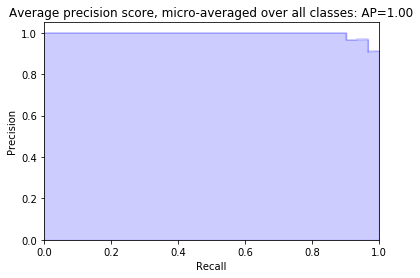

In [12]:
evaluate('linear')

#### Polynomial Kernel Based SVM

class 1 precision score: 1.00
class 2 precision score: 1.00
class 3 precision score: 0.50
class 4 precision score: 1.00
class 5 precision score: 1.00
class 6 precision score: 1.00
class 7 precision score: 0.92
Average precision score, micro-averaged over all classes: 0.98


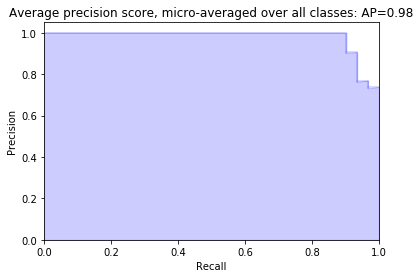

In [13]:
evaluate('poly')

#### RBF Kernel Based SVM

class 1 precision score: 1.00
class 2 precision score: 1.00
class 3 precision score: 1.00
class 4 precision score: 1.00
class 5 precision score: 1.00
class 6 precision score: 1.00
class 7 precision score: 1.00
Average precision score, micro-averaged over all classes: 0.99


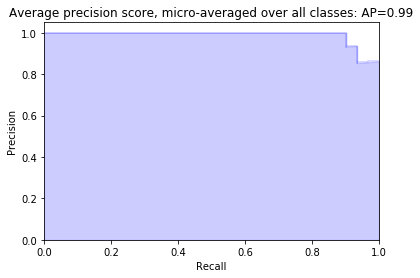

In [14]:
evaluate('rbf')

#### Sigmoid Kernel Based SVM

class 1 precision score: 0.78
class 2 precision score: 0.37
class 3 precision score: 1.00
class 4 precision score: 1.00
class 5 precision score: 0.08
class 6 precision score: 0.08
class 7 precision score: 0.63
Average precision score, micro-averaged over all classes: 0.65


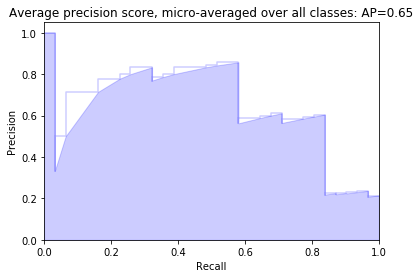

In [15]:
evaluate('sigmoid')

#### Neural Network Based SVM

class 1 precision score: 1.00
class 2 precision score: 1.00
class 3 precision score: 0.12
class 4 precision score: 1.00
class 5 precision score: 0.33
class 6 precision score: 0.87
class 7 precision score: 0.92
Average precision score, micro-averaged over all classes: 0.94


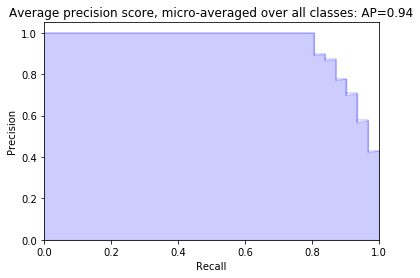

In [16]:
evaluate('nn')